In [1]:
import keras as k
import keras.backend as K
import numpy as np 
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adadelta
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
(x_train_master, y_train_master), (x_test_master, y_test_master) = k.datasets.fashion_mnist.load_data()
x_train_master = x_train_master /  255
x_test_master = x_test_master / 255

In [3]:
x_train_master = np.expand_dims(x_train_master, 3)
x_test_master = np.expand_dims(x_test_master, 3)

In [4]:
x_train_master.shape

(60000, 28, 28, 1)

In [5]:
y_train_master = y_train_master.flatten()
y_test_master = y_test_master.flatten()

In [6]:
num_train_per_class = 1
n_epochs = 10

In [7]:
def generate_triplets(dataset, label, sample_per_class=10):
  x, y = None, None
  for i in range(10):
    pos_indices = np.argwhere(label == i)[:,0]
    neg_indices = np.argwhere(label != i)[:,0]
    
    choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_anchor = pos_indices[choice_anchor]

    choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_pos = pos_indices[choice_pos]

    choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=False)
    choice_neg = neg_indices[choice_neg]

    sub_x_anc = dataset[choice_anchor]
    
    sub_x_pos = dataset[choice_pos]

    sub_x_neg = dataset[choice_neg]
      
        
    if(x is None):
      x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
      y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
    else:
      x[0] = np.vstack((x[0], (sub_x_anc)))
      x[1] = np.vstack((x[1], (sub_x_pos)))
      x[2] = np.vstack((x[2], (sub_x_neg)))

      y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
      y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
      y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
    
  return x, y

In [8]:
train_x, train_y = generate_triplets(x_train_master, y_train_master)

In [9]:
train_x[0].shape

(100, 28, 28, 1)

In [10]:
def visualize_data(data, n):
  n = min(len(data[0]), n)
  random_choices = np.random.choice(len(data[0]),n, replace=False)
  fig, ax = plt.subplots(n, 3,figsize=(10,40))
  anc, pos, neg = data
  for i,ch in enumerate(random_choices):
    ax[i, 0].imshow(np.squeeze(anc[ch] ))
    ax[i, 1].imshow(np.squeeze(pos[ch] ))
    ax[i, 2].imshow(np.squeeze(neg[ch] ))
    

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].set_axis_off()

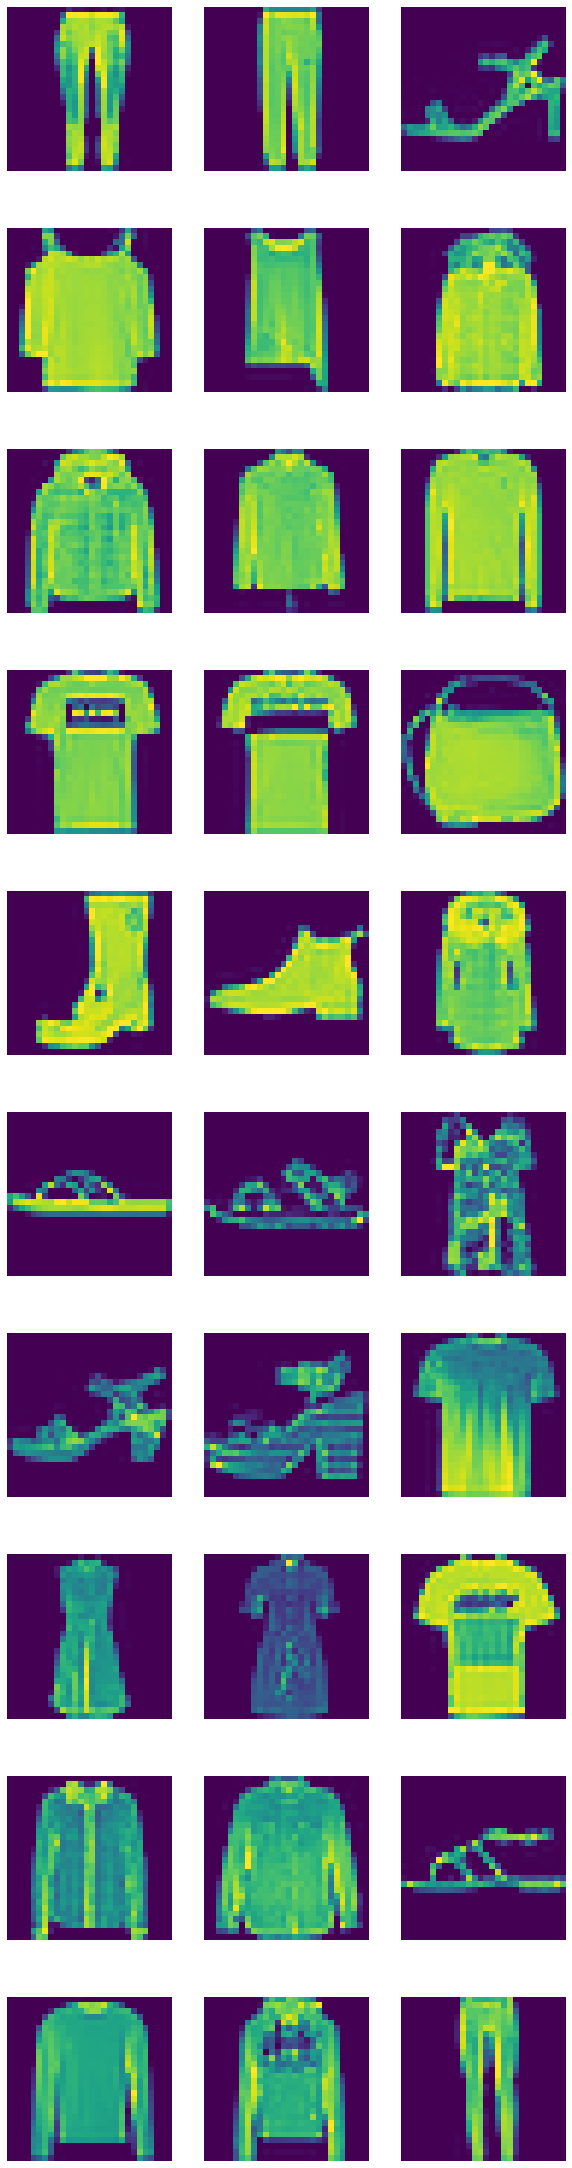

In [11]:
visualize_data(train_x, 10)

In [12]:
train_x, train_y = generate_triplets(x_train_master, y_train_master, num_train_per_class)
test_x, test_y = generate_triplets(x_test_master, y_test_master,5)

In [13]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

def get_embedding_model(input_shape, embedding_dim):
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(embedding_dim * 4,activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    return Model(_input, x)
        

def get_siamese_model(input_shape, triplet_margin=.3, embedding_dim=50):

    # Define the tensors for the triplet of input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    # Convolutional Neural Network (same from earlier)
    embedding_model = get_embedding_model(input_shape, embedding_dim)
    
    # Generate the embedding outputs 
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    # Connect the inputs with the outputs
    siamese_triplet = Model(inputs=inputs,outputs=outputs)
    
    siamese_triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus')))
    
    # return the model
    return embedding_model, siamese_triplet

# Siamese NN trained on 9 classes


In [33]:
embedding_model, siamese_triplet = get_siamese_model((28,28,1), triplet_margin=.3, embedding_dim=150)
siamese_triplet.compile(loss=None, optimizer=Adam(0.0001))

In [34]:
history = siamese_triplet.fit(x=train_x, shuffle=True, batch_size=1000,
                              validation_split=.1, epochs=n_epochs)

Epoch 1/10
1/1 [==============================] - 0s 328ms/step - loss: 1.0711 - val_loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.8119 - val_loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 29ms/step - loss: 0.5829 - val_loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 35ms/step - loss: 0.4175 - val_loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 47ms/step - loss: 0.2781 - val_loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 42ms/step - loss: 0.1621 - val_loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 53ms/step - loss: 0.0797 - val_loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 50ms/step - loss: 0.0074 - val_loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 46ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - v

In [ ]:
train_embeds = embedding_model.predict(np.vstack((train_x[0], train_x[1], train_x[2])))

In [40]:
target = np.hstack((train_y[0], train_y[1], train_y[2]))

In [41]:
from sklearn.neighbors import KNeighborsClassifier
def fit_nearest_neighbor(img_encoding, img_class, algorithm='ball_tree'):
  classifier = KNeighborsClassifier(n_neighbors=3, algorithm=algorithm)
  classifier.fit(img_encoding, img_class)
  return classifier

In [42]:
classifier = fit_nearest_neighbor(train_embeds, target)

In [43]:
e = embedding_model.predict(x_test_master)
op = classifier.predict(e)

In [44]:
(np.where(y_test_master == op))[0].shape[0] / y_test_master.shape[0]

0.4954